### Dataset generation from video
- Create a folder storing the video files. For example
``` 
./video_files/
 |--stable.avi
 |--unstable.avi
```
- Perform initial frame inspection to define four roller regions
- Analyze Video File
- Experiment with `HoughCircle` and `bilateralFilter` (may have to use different filter/blur) parameters to increase accuracy

#### Import Required Packages

In [1]:
import cv2
import csv
import os
import numpy as np
import matplotlib.pyplot as plt

#### Marker Detector Function
(You may need to use filter/blur methods other than bilateral filters)

In [2]:
def circular_marker_detector(image: np.ndarray,  
                             param1: float, param2: float, 
                             minRadius: int, maxRadius: int, 
                             bil_filter_params: dict={'d':7, 'sigmaColor':75.0, 'sigmaSpace': 75.0}) -> np.ndarray: 
    """Detects Circular Markers

    Args:
        image (np.ndarray): Image
        param1 (float): HoughCircle Parameter
        param2 (float): HoughCircle Parameter
        minRadius (int): Minimum radius of the circle (in pixels)
        maxRadius (int): Maximum radius of the circle (in pixels)
        bil_filter_params (dict, optional): Bilateral Filter Parameters. Defaults to {'d':7, 'sigmaColor':75.0, 'sigmaSpace': 75.0}.

    Returns:
        np.ndarray: Numpy array in the form of np.array([row, column, radius], dtype=np.uint16)
                    (row, column) -> The marker coordinate inside image
                    radius        -> Radius of the circle
    """
    # Apply bilateral filter for edge smoothening
    blurred = cv2.bilateralFilter(image, **bil_filter_params)

    # OPTIMIZE `param1`, `param2`, `minRadius`, and `maxRadius`
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1, minDist=blurred.shape[0]/64,
                            param1=param1, param2=param2, 
                            minRadius=minRadius, maxRadius=maxRadius)
    # Check if the two markers are detected properly
    # Otherwise set the coordinate and radius to zero
    if circles is None or circles.shape[1] != 2:
        circles = np.array([[[0, 0, 0], [0, 0, 0]]])
    
    circles = np.uint16(np.around(circles))
    return circles[0,:]

#### Angle Calculator

In [3]:
def calc_theta(center: np.ndarray, marker1: np.ndarray, marker2: np.ndarray) -> float:
    """Calculates Angle POQ where P, O, and Q are three markers circular markers in the following form:
       np.array([row, column, radius], dtype=np.uint16)
       (row, column) -> The marker coordinate inside image
       radius        -> Radius of the circle

    Args:
        center (np.ndarray):  O
        marker1 (np.ndarray): P
        marker2 (np.ndarray): Q

    Returns:
        float: theta (degrees)
    """
    # If any marker has a zero radius -> Markers were not identified properly -> return Nan
    if center[2] == 0 or marker1[2] == 0 or marker2[2] == 0:
        return np.nan
    # Convert the arrays into int16 from uint16 and Take only first two elements (row, col) coordinates
    center = center.astype(np.int16)[:2]
    marker1 = marker1.astype(np.int16)[:2]
    marker2 = marker2.astype(np.int16)[:2]
    # Define P and Q vectors
    p = np.subtract(marker1, center)
    q = np.subtract(marker2, center)
    # Calculate magnitudes
    mod_p = np.linalg.norm(p)
    mod_q = np.linalg.norm(q)
    # Calculate Dot Product
    p_dot_q = np.dot(p, q)
    # Calculate Angle
    cos_theta = np.clip(p_dot_q / (mod_p*mod_q), -1.0, 1.0)
    theta_deg = 180*np.arccos(cos_theta)/np.pi

    return theta_deg

#### Image Frame Processor
Experiment with the following parameters:
- `param1`
- `param2`
- `minRadius`
- `maxRadius`
- `bil_filter_params` (You may need to use other image filtering techniques)

In [27]:
def frame_processor(image: np.ndarray, bounding_boxes: list[tuple]) -> tuple:
    """Processes the each image frame

    Args:
        image (np.ndarray): Image Frame
        bounding_boxes (list[tuple]): Upper (u) and Lower (l) limits of row (r) and column (c) for the four roller regions
                                      bounding_boxes = [(A1_rl, A1_ru, A1_cl, A1_cu), # A1
                                                        (A2_rl, A2_ru, A2_cl, A2_cu), # A2
                                                        (B1_rl, B1_ru, B1_cl, B1_cu), # B1
                                                        (B2_rl, B2_ru, B2_cl, B2_cu)] # B2
    Returns:
        tuple: (image, theta)
        image -> Marked Image Frame
        theta -> Calculated theta values np.array([theta1, theta2, theta3, theta4]) for the rollers
    """
    # Convert Image into gray and equalize the histogram
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # ROLLER REGION
    # Bounding boxes (r -> row, c -> col, l -> lower, u -> upper)
    A1_rl, A1_ru, A1_cl, A1_cu = bounding_boxes[0] # A1
    A2_rl, A2_ru, A2_cl, A2_cu = bounding_boxes[1] # A2
    B1_rl, B1_ru, B1_cl, B1_cu = bounding_boxes[2] # B1
    B2_rl, B2_ru, B2_cl, B2_cu = bounding_boxes[3] # B2

    # Region Origins
    orgs = [(A1_cl, A1_rl), (A2_cl, A2_rl), (B1_cl, B1_rl), (B2_cl, B2_rl)]

    # Get image data from each boxes
    A1 = img_gray[A1_rl:A1_ru, A1_cl:A1_cu]
    A2 = img_gray[A2_rl:A2_ru, A2_cl:A2_cu]
    B1 = img_gray[B1_rl:B1_ru, B1_cl:B1_cu]
    B2 = img_gray[B2_rl:B2_ru, B2_cl:B2_cu]

    # Detect markers (roller portion)
    # Experment with the parameters to get the best result
    filter_params = {'d':7, 'sigmaColor':75.0, 'sigmaSpace': 75.0}
    A1_markers = circular_marker_detector(image=A1, param1=17, param2=16, minRadius=2, maxRadius=9, bil_filter_params=filter_params)
    A2_markers = circular_marker_detector(image=A2, param1=17, param2=16, minRadius=2, maxRadius=9, bil_filter_params=filter_params)
    B1_markers = circular_marker_detector(image=B1, param1=17, param2=16, minRadius=2, maxRadius=9, bil_filter_params=filter_params)
    B2_markers = circular_marker_detector(image=B2, param1=17, param2=16, minRadius=2, maxRadius=9, bil_filter_params=filter_params)
    marker_list = [A1_markers, A2_markers, B1_markers, B2_markers]
    
    # Draw marker - center, marker1, marker2
    for markers, org in zip(marker_list, orgs):
        # Origin point for each marker
        cl0, rl0 = org      
        for i in markers:
            if i[2] == 0: # If the marker radius is zero skip drawing
                continue
            i[0] = i[0]+cl0 # Corrected col
            i[1] = i[1]+rl0 # Corrected row
            # outer circle
            cv2.circle(image,(i[0],i[1]),i[2],(255,0,0),2)
            # center of the circle
            cv2.circle(image,(i[0],i[1]),1,(0,255,0),2)

    # Get the center markers
    centers = []
    for mks in marker_list:
        center_idx = np.argmax(mks[:, 2]) # Get the row index where the radius value is the maximum (since center radius is bigger the marker1)
        centers.append(mks[center_idx])   # Append the center marker in centers list  
    
    markers1 = []
    for mks in marker_list:
        marker1_idx = np.argmin(mks[:, 2]) # Get the row index where the radius value is the minimum (since marker1 radius is smaller than center)
        markers1.append(mks[marker1_idx])  # Append the marker1 in the markers1 list 
    
    # Create Marker2 at a vertical offset of `vline` from the center
    vline = 70          # Make sure that this offset does not exceed the image height
    marker2_radius = 5  # marker1 radius = marker2 radius for simplicity
    markers2 = []
    # Make a copy of centers for marker2
    for c in centers:
        markers2.append(np.array([c[0], c[1], c[2]]))
    # Set radius and shift marker2 vertically
    for j in markers2:
        j[1] = j[1] - vline
        j[2] = marker2_radius
        # outer circle
        cv2.circle(image,(j[0],j[1]),j[2],(0,0,255),2)
        # center of the circle
        cv2.circle(image,(j[0],j[1]),1,(0,255,0),2)

    # Draw connecting line between centers and markers2
    for (i,j) in zip(centers, markers2):
        cv2.line(image, (i[0], i[1]), (j[0], j[1]), (125, 125, 125), 2)

    # Calculate Angle Between the Three markers at the center
    theta = np.array([calc_theta(c, mk1, mk2) for c, mk1, mk2 in zip(centers, markers1, markers2)])   

    return (image, theta)

#### CSV Data Writer

In [5]:
def csvWriter(csv_filepath: str, data: np.ndarray, label: str):
    """Writes Generated Theta Values and Frame Label into a .csv file

    Args:
        csv_filepath (str): .csv file path
        data (np.ndarray): np.array([theta1, theta2, theta3, theta4], dtype=float)
        label (str): 'stable' or 'unstable'
    """
    file = os.path.isfile(csv_filepath)
    with open(csv_filepath, mode='a', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile, delimiter=",")
        # Add headers if the file did not exist before
        if not file:
            headers = ["theta1", "theta2", "theta3", "theta4", "label"]
            writer.writerow(headers)
        # Write Theta Values and Label 
        writer.writerow([*data.tolist(), label])

#### Video Data Analyzer

In [6]:
def video_data_analyzer(video_input_path: str, vid_output_path:str, data_output_path: str, bounding_boxes: list[tuple], label: str):
    """Analyzes Video File

    Args:
        video_input_path (str): Input Video File Path
        vid_output_path (str): Output Video File Path
        data_output_path (str): Output .csv File Path
        bounding_boxes (list[tuple]): Upper (u) and Lower (l) limits of row (r) and column (c) for the four roller regions
                                      bounding_boxes = [(A1_rl, A1_ru, A1_cl, A1_cu), # A1
                                                        (A2_rl, A2_ru, A2_cl, A2_cu), # A2
                                                        (B1_rl, B1_ru, B1_cl, B1_cu), # B1
                                                        (B2_rl, B2_ru, B2_cl, B2_cu)] # B2
        label (str): 'stable' or 'unstable'
    """
    # Directories
    videofile = os.path.abspath(video_input_path)

    # Capture Video
    cap = cv2.VideoCapture(videofile)
    #cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*"XVID")
    video_out_path = os.path.abspath(vid_output_path)
    out = cv2.VideoWriter(video_out_path, fourcc, fps, (width,  height))

    # VideoPlayBack
    cv2.namedWindow('VideoFeed', cv2.WINDOW_NORMAL) 

    if cap.isOpened() == False:
        raise Exception("Error: Cannot Open File")
    
    while cap.isOpened():
        ret, frame = cap.read() # read each frame
        if ret:
            # MAIN IMAGE PROCESSING CODE
            frame_processed, theta_values = frame_processor(frame, bounding_boxes)
            # Create .csv file
            data_out = os.path.abspath(data_output_path)
            csvWriter(data_out, theta_values, label)
            # Videoplayback
            cv2.imshow("VideoFeed", frame_processed)
            out.write(frame_processed)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            break
    cap.release() # Stop capturing
    out.release() # Stop writing
    cv2.destroyAllWindows()   # Close all windows if videoplayback is on

#### Initial Image Frame Inspection
- Take a image frame from the video file
- Explore Image Width $\times$ Height
- Define four distinct regions

#### Random Frame Generator

In [7]:
def get_random_frame(video_path: str) -> str:
    """
    Extracts a random frame from a video file and saves it as an image.

    Args:
        video_path (str): The path to the video file.
        output_filename (str): The desired name for the output image file.
    """
    cap = cv2.VideoCapture(os.path.abspath(video_path))
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    seed_number = np.random.randint(low=0, high=total_frames - 1, size=1)[0]
    cap.set(cv2.CAP_PROP_POS_FRAMES, seed_number)
    output_basename = os.path.basename(video_path).split(".")[0]
    output_dir = os.path.dirname(video_path)
    output_filename = output_basename+f"-frame-{seed_number}.jpg"
    output_path = os.path.join(output_dir, output_filename)
    success, frame = cap.read()
    if success:
        cv2.imwrite(output_path, frame)
        print(f"Successfully saved frame {seed_number} at {output_path}")
    else:
        print(f"Error: Could not read frame {seed_number}.")
    cap.release()

    return output_path

In [10]:
img_path = get_random_frame("./video_files/unstable.avi")

Successfully saved frame 1488 at ./video_files\unstable-frame-1488.jpg


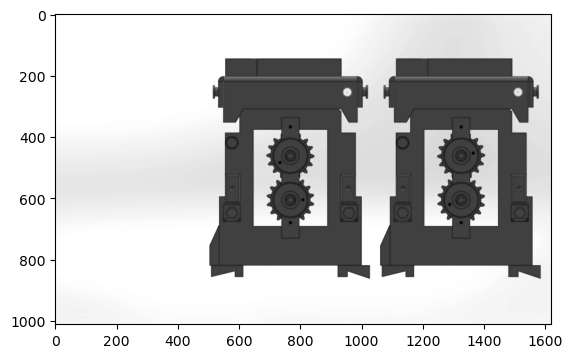

In [12]:
# Read Image
img = cv2.imread(img_path)
# Convert Image into gray and apply blurr
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_filtered = cv2.bilateralFilter(img_gray, d=7, sigmaColor=75, sigmaSpace=75)
plt.imshow(img_filtered, cmap="gray")

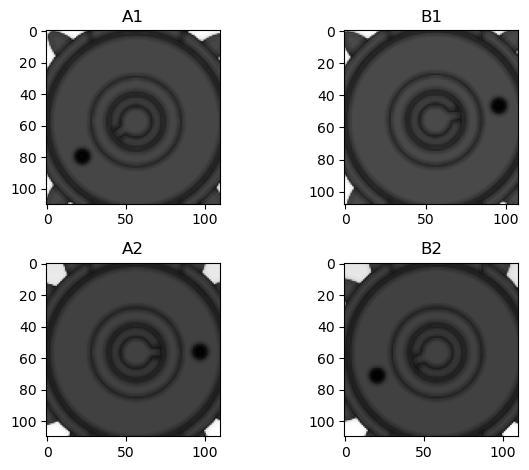

In [13]:
# Bounding boxes (r -> row, c -> col, l -> lower, u -> upper)
A1_rl, A1_ru, A1_cl, A1_cu = 405, 515, 712, 822
A2_rl, A2_ru, A2_cl, A2_cu = 550, 660, 712, 822
B1_rl, B1_ru, B1_cl, B1_cu = 407, 515, 1270, 1378
B2_rl, B2_ru, B2_cl, B2_cu = 550, 660, 1268, 1378

# Get image data from each boxes
A1 = img_filtered[A1_rl:A1_ru, A1_cl:A1_cu]
A2 = img_filtered[A2_rl:A2_ru, A2_cl:A2_cu]
B1 = img_filtered[B1_rl:B1_ru, B1_cl:B1_cu]
B2 = img_filtered[B2_rl:B2_ru, B2_cl:B2_cu]

fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(A1, cmap='gray')
axs[0, 0].set_title("A1")

axs[1, 0].imshow(A2, cmap='gray')
axs[1, 0].set_title("A2")

axs[0, 1].imshow(B1, cmap='gray')
axs[0, 1].set_title("B1")

axs[1, 1].imshow(B2, cmap='gray')
axs[1, 1].set_title("B2")

plt.tight_layout()
plt.show()

#### Define Bounding Boxes

In [14]:
# Define Bounding Box (row_lower_limit, row_upper_limit, col_lower_limit, col_upper_limit )
A1_bbox = (405, 515, 712, 822)
A2_bbox = (550, 660, 712, 822)
B1_bbox = (407, 515, 1270, 1378)
B2_bbox = (550, 660, 1268, 1378)
bboxes = [A1_bbox, A2_bbox, B1_bbox, B2_bbox]

#### Analyze Video for `stable` class

In [ ]:
video_in = "./video_files/ENTER_VIDEO_FILE"     # Input Video File Path
video_out = "./video_files/stable_marked.avi" # Output Video File Path
data_out = "./data_out.csv"                     # Output .csv File Path
video_data_analyzer(video_input_path=video_in, 
                    vid_output_path=video_out, 
                    data_output_path=data_out,
                    bounding_boxes=bboxes, 
                    label='stable')

#### Analyze Video for `unstable` class

In [28]:
video_in = "./video_files/unstable.avi"         # Input Video File Path
video_out = "./video_files/unstable_marked.avi" # Output Video File Path
data_out = "./data_out.csv"                     # Output .csv File Path
video_data_analyzer(video_input_path=video_in, 
                    vid_output_path=video_out, 
                    data_output_path=data_out,
                    bounding_boxes=bboxes, 
                    label='unstable')